# Отток клиентов

# 1. Подготовка данных

In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [27]:
data = pd.read_csv('/datasets/Churn.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


У примерно 1000 человек нет данных о недвижимости (столбец Tenure). Кроме того, тип данных не соответствует значениям (полтора дома быть не может). Посмотрим на распределение значений.

,Balance
Tenure,
0.0,382
1.0,952
2.0,950
3.0,928
4.0,885
5.0,927
6.0,881
7.0,925
8.0,933


Среднее: 4.997690023099769
Медиана: 5.0


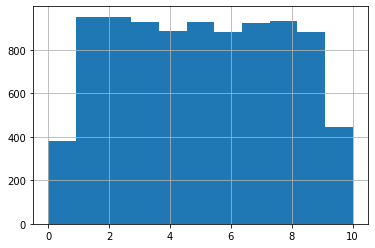

In [28]:
pt = data.pivot_table(index='Tenure', values='Balance', aggfunc='count')
display(pt)
data['Tenure'].hist(bins=11)
print('Среднее:', data['Tenure'].mean())
print('Медиана:', data['Tenure'].median())

Распределение значений крайне ровное. Среднее практически равно медиане. По графику видно, что выбиваются 0 и 10, т.е. у меньшинства нет недвижимости вообще либо есть 10 домов. Исходя из этого, можем заполнить пропуски по медиане.

Помимо этого, нужно избавиться от строковых значений методом OHE. В новом датафрейме уберем фамилию (т.к. она не влияет на вероятность ухода клиента) и запустим OHE.

In [29]:
data['Tenure'] = data['Tenure'].fillna(5).astype('int') #медиана равна 5
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [30]:
pt = data.pivot_table(index='Geography', values='Exited', aggfunc='sum')
display(pt)
pt_count = data.pivot_table(index='Geography', values='Exited', aggfunc='count')
pt_count

,Exited
Geography,
France,810
Germany,814
Spain,413


,Exited
Geography,
France,5014
Germany,2509
Spain,2477


# 2. Исследование задачи

In [31]:
#сводная таблица по классам
pt = data.pivot_table(index='Exited', values='Balance', aggfunc='count')
pt

,Balance
Exited,
0,7963
1,2037


У нас задача классификации. Сравним модели случайного леса (RandomForestClassifier) и логистической регрессии (LogisticRegression). В исходных данных имеется дисбаланс классов: 80% активных клиентов против 20% вышедших. Сначала обучим модели без учета дисбаланса.

In [32]:
# OHE

#убираем лишние столбцы: фамилия, номер строки и id клиента не влияют на вероятность его выхода из банка
data_ohe = data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
data_ohe = pd.get_dummies(data_ohe, drop_first=True)
print(data_ohe.info())
data_ohe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB
None


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [33]:
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']

#делим данные на обучающую и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

In [34]:
features

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,0,1


In [35]:
%%time
#подбираем гиперпараметры случайного леса и смотрим на точность. Сначала подбираем n_estimators, глубину ставим 10
for i in range (10, 110, 10):
    model = RandomForestClassifier(n_estimators=i, max_depth=10, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    confusion = confusion_matrix(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    precision = precision_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print('Случайный лес, n_estimators={}'.format(i))
    print('Матрица ошибок:', confusion)
    print('Точность:', recall)
    print('Полнота:', precision)
    print('F1-мера:', f1)
    print()

Случайный лес, n_estimators=10
Матрица ошибок: [[1900   65]
 [ 304  231]]
Точность: 0.43177570093457945
Полнота: 0.7804054054054054
F1-мера: 0.555956678700361

Случайный лес, n_estimators=20
Матрица ошибок: [[1910   55]
 [ 317  218]]
Точность: 0.4074766355140187
Полнота: 0.7985347985347986
F1-мера: 0.5396039603960396

Случайный лес, n_estimators=30
Матрица ошибок: [[1910   55]
 [ 313  222]]
Точность: 0.41495327102803736
Полнота: 0.8014440433212996
F1-мера: 0.5467980295566502

Случайный лес, n_estimators=40
Матрица ошибок: [[1912   53]
 [ 309  226]]
Точность: 0.4224299065420561
Полнота: 0.8100358422939068
F1-мера: 0.5552825552825552

Случайный лес, n_estimators=50
Матрица ошибок: [[1914   51]
 [ 314  221]]
Точность: 0.4130841121495327
Полнота: 0.8125
F1-мера: 0.5477075588599752

Случайный лес, n_estimators=60
Матрица ошибок: [[1911   54]
 [ 316  219]]
Точность: 0.4093457943925234
Полнота: 0.8021978021978022
F1-мера: 0.5420792079207921

Случайный лес, n_estimators=70
Матрица ошибок: [[19

При n_estimators >= 70 матрицы ошибок выглядят практически одинаково. При этом незначительно различаются точность и полнота, а F1-мера различается только с 3 знака после запятой. Пока возьмем n_estimators=70 для быстродействия.

In [36]:
%%time
#Теперь подбираем глубину:
for depth in range(1, 16, 1):
    model = RandomForestClassifier(n_estimators=70, max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    confusion = confusion_matrix(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    precision = precision_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print('Случайный лес, max_depth={}'.format(depth))
    print('Матрица ошибок:', confusion)
    print('Точность:', recall)
    print('Полнота:', precision)
    print('F1-мера:', f1)
    print()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Случайный лес, max_depth=1
Матрица ошибок: [[1965    0]
 [ 535    0]]
Точность: 0.0
Полнота: 0.0
F1-мера: 0.0

Случайный лес, max_depth=2
Матрица ошибок: [[1965    0]
 [ 497   38]]
Точность: 0.07102803738317758
Полнота: 1.0
F1-мера: 0.13263525305410123

Случайный лес, max_depth=3
Матрица ошибок: [[1957    8]
 [ 465   70]]
Точность: 0.1308411214953271
Полнота: 0.8974358974358975
F1-мера: 0.22838499184339314

Случайный лес, max_depth=4
Матрица ошибок: [[1943   22]
 [ 410  125]]
Точность: 0.2336448598130841
Полнота: 0.8503401360544217
F1-мера: 0.3665689149560117

Случайный лес, max_depth=5
Матрица ошибок: [[1932   33]
 [ 370  165]]
Точность: 0.308411214953271
Полнота: 0.8333333333333334
F1-мера: 0.4502046384720327

Случайный лес, max_depth=6
Матрица ошибок: [[1929   36]
 [ 343  192]]
Точность: 0.35887850467289717
Полнота: 0.8421052631578947
F1-мера: 0.5032765399737876

Случайный лес, max_depth=7
Матрица ошибок: [[1921   44]
 [ 326  209]]
Точность: 0.39065420560747666
Полнота: 0.8260869565

Наилучшие результаты достигаются при max_depth = 11.

Итак, гиперпараметры для случайного леса: <u>n_estimators=70</u> и <u>max_depth=11</u>.

In [37]:
model = LogisticRegression()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
confusion = confusion_matrix(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
precision = precision_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
print('Матрица ошибок:', confusion)
print('Точность:', recall)
print('Полнота:', precision)
print('F1-мера:', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Матрица ошибок: [[1921   44]
 [ 499   36]]
Точность: 0.06728971962616823
Полнота: 0.45
F1-мера: 0.11707317073170732


**Вывод:** логистическая регрессия в данном случае сильно отстает от случайного леса.

# 3. Борьба с дисбалансом

Для алгоритмов случайного леса и регрессии проверим, как работает upsample и downsample. Исходя из результатов будем выбирать, что лучше.

In [38]:
#функция upsample
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

#функция downsample
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled)
    return features_downsampled, target_downsampled

In [39]:
#сначала считаем апсемплинг
features_ohe_upsampled, target_ohe_upsampled = upsample(features_train, target_train, 4)
features_train_us, features_valid_us, target_train_us, target_valid_us = train_test_split(features_ohe_upsampled,
                                                                             target_ohe_upsampled,
                                                                             test_size=0.25,
                                                                             random_state=12345)
#даунсемплинг
features_ohe_downsampled, target_ohe_downsampled = downsample(features, target, 0.25)
features_train_ds, features_valid_ds, target_train_ds, target_valid_ds = train_test_split(features_ohe_downsampled,
                                                                             target_ohe_downsampled,
                                                                             test_size=0.25,
                                                                             random_state=12345)

In [40]:
#обучение модели
model_forest = RandomForestClassifier(n_estimators=70, max_depth=11, random_state=12345)
model_forest.fit(features_train_us, target_train_us)
predicted_valid_us = model_forest.predict(features_valid_us)
#проверяем качество
confusion = confusion_matrix(target_valid_us, predicted_valid_us)
recall = recall_score(target_valid_us, predicted_valid_us)
precision = precision_score(target_valid_us, predicted_valid_us)
f1 = f1_score(target_valid_us, predicted_valid_us)
print('Случайный лес после апсемплинга')
print('Матрица ошибок:', confusion)
print('Точность:', recall)
print('Полнота:', precision)
print('F1-мера:', f1)
print()

#теперь с даунсемплингом
model_forest.fit(features_train_ds, target_train_ds)
predicted_valid_ds = model_forest.predict(features_valid_ds)
confusion = confusion_matrix(target_valid_ds, predicted_valid_ds)
recall = recall_score(target_valid_ds, predicted_valid_ds)
precision = precision_score(target_valid_ds, predicted_valid_ds)
f1 = f1_score(target_valid_ds, predicted_valid_ds)
print('Случайный лес после даунсемплинга')
print('Матрица ошибок:', confusion)
print('Точность:', recall)
print('Полнота:', precision)
print('F1-мера:', f1)

Случайный лес после апсемплинга
Матрица ошибок: [[1325  201]
 [ 150 1326]]
Точность: 0.8983739837398373
Полнота: 0.8683693516699411
F1-мера: 0.8831168831168831

Случайный лес после даунсемплинга
Матрица ошибок: [[386 100]
 [127 394]]
Точность: 0.7562380038387716
Полнота: 0.7975708502024291
F1-мера: 0.7763546798029557


Теперь то же самое делаем для логистической регрессии.

In [41]:
model_regression = LogisticRegression()
#апсемплинг
model_regression.fit(features_train_us, target_train_us)
predicted_valid_us = model_regression.predict(features_valid_us)
#качество
confusion = confusion_matrix(target_valid_us, predicted_valid_us)
recall = recall_score(target_valid_us, predicted_valid_us)
precision = precision_score(target_valid_us, predicted_valid_us)
f1 = f1_score(target_valid_us, predicted_valid_us)
print('Регрессия после апсемплинга')
print('Матрица ошибок:', confusion)
print('Точность:', recall)
print('Полнота:', precision)
print('F1-мера:', f1)
print()

#даунсемплинг
model_regression.fit(features_train_ds, target_train_ds)
predicted_valid_ds = model_regression.predict(features_valid_ds)
#качество
confusion = confusion_matrix(target_valid_ds, predicted_valid_ds)
recall = recall_score(target_valid_ds, predicted_valid_ds)
precision = precision_score(target_valid_ds, predicted_valid_ds)
f1 = f1_score(target_valid_ds, predicted_valid_ds)
print('Регрессия после даунсемплинга')
print('Матрица ошибок:', confusion)
print('Точность:', recall)
print('Полнота:', precision)
print('F1-мера:', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Регрессия после апсемплинга
Матрица ошибок: [[ 991  535]
 [ 464 1012]]
Точность: 0.6856368563685636
Полнота: 0.654169360051713
F1-мера: 0.6695335759179623

Регрессия после даунсемплинга
Матрица ошибок: [[322 164]
 [148 373]]
Точность: 0.7159309021113244
Полнота: 0.6945996275605214
F1-мера: 0.7051039697542534


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Выводы.**
- Больше всего ребалансировка классов влияет на логистическую регрессию;
- Несмотря на ребалансировку, качество модели регрессии отстает от случайного леса;
- Ребалансировка класса значительно увеличила полноту модели случайного леса, соответственно выросла F1-мера. Также незначительно увеличилась точность модели.

Для дальнейшей работы будем использовать обученную модель случайного леса.

# 4. Тестирование модели

In [42]:
#обучаем модель по апсемплингу
model_forest_final = RandomForestClassifier(n_estimators=70,
                                            max_depth=11,
                                            random_state=12345)
##model_forest_final.fit(features_ohe_upsampled, target_ohe_upsampled) было
model_forest_final.fit(features_train, target_train) #стало
#проверяем по исходным данным после OHE
##features = data_ohe.drop('Exited', axis=1) было
##target = data_ohe['Exited']                было  
##predicted_target = model_forest_final.predict(features)  было
predicted_target = model_forest_final.predict(features_valid)   #стало

#оцениваем качество
##confusion = confusion_matrix(target, predicted_target)
##recall = recall_score(target, predicted_target)
##precision = precision_score(target, predicted_target)
##f1 = f1_score(target, predicted_target)
print('Случайный лес на всех данных')
##print('Матрица ошибок:', confusion)
##print('Точность:', recall)
##print('Полнота:', precision)
##print('F1-мера:', f1)
print('F1-мера новая:', f1_score(target_valid, predicted_target))

Случайный лес на всех данных
F1-мера новая: 0.5543345543345544


Метрика ROC-AUC: 0.861643242729067


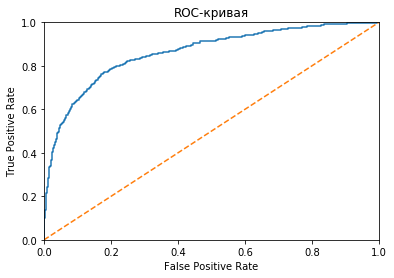

In [43]:
#исследуем AUC-ROC
probabilities = model_forest_final.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one)
print('Метрика ROC-AUC:', roc_auc)

#строим график
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

#ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

In [44]:
#проверка: обучение модели с параметром class_weight='balanced'
model_forest_check = RandomForestClassifier(n_estimators=70,
                                           max_depth=11,
                                           random_state=12345,
                                           class_weight='balanced')
#обучаем модель по исходным данным
#features = data_ohe.drop(['Exited'], axis=1)
#target = data_ohe['Exited']

model_forest_check.fit(features_train, target_train)
predicted_check = model_forest_check.predict(features_valid)

#проверяем качество модели
confusion = confusion_matrix(target_valid, predicted_check)
recall = recall_score(target_valid, predicted_check)
precision = precision_score(target_valid, predicted_check)
f1 = f1_score(target_valid, predicted_check)
print('Случайный лес на исходных данных')
print('Матрица ошибок:', confusion)
print('Точность:', recall)
print('Полнота:', precision)
print('F1-мера:', f1)

Случайный лес на исходных данных
Матрица ошибок: [[1795  170]
 [ 209  326]]
Точность: 0.6093457943925233
Полнота: 0.657258064516129
F1-мера: 0.632395732298739


ROC-AUC: 0.8601412570450166


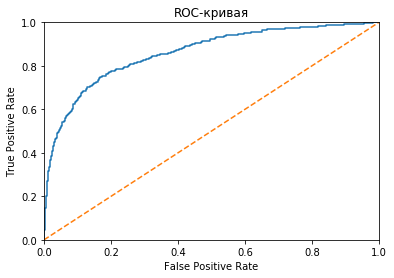

In [45]:
#считаем AUC-ROC на проверочной модели
probabilities_check = model_forest_check.predict_proba(features_valid)
prob_check_ones = probabilities_check[:, 1]
roc_auc = roc_auc_score(target_valid, prob_check_ones)
print('ROC-AUC:', roc_auc)

#строим график
fpr, tpr, thresholds = roc_curve(target_valid, prob_check_ones)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

#ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

**Вывод.** В результате проекта удалось получить модель с достаточно высокой точностью предсказания ухода клиента из банка. Лучше всего себя показала модель случайного леса с гиперпараметрами n_estimators=70 и max_depth=11, обученная на сбалансированном массиве данных. Модель была протестирована на исходном массиве данных со следующими результатами:
- Точность: 0.60
- Полнота: 0.66
- F1-мера: 0.63
- AUC-ROC: 0.86

Наилучшим образом проявила себя ребалансировка классов методом upsampling. Наибольший эффект заметен на модели логистической регрессии.